In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from pathlib import Path
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb

# Cribbed from
# https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [5]:
# Load
pn_excel = Path('Building Equipment - Deidentified.xlsx')
pn_pkl = Path('data.pkl')
if pn_pkl.exists():
#if False:
    df = pd.read_pickle(pn_pkl)
else:
    df = pd.read_excel(pn_excel)
    df = df.set_index('id')
    df.to_pickle('data.pkl')

# replace null labels
if 'system_type' in df.columns:
    df.loc[df.system_type.isnull(), 'system_type'] = 'Unknown'
    

In [6]:
def clean_df(df):
    # drop columns that make it too easy
    df = df.drop(['system_name','monthly_profile', 'percent_total', 'equipment_number'], axis=1, errors='ignore')
    
    # Convert these ones (trivially) to numbers
    convert_cols = ['nameplate_hp', 'V','hp','scheduled_hours_per_day']
    for c in convert_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Uppercase remaining strings 
    for c in df.select_dtypes('object').columns:
        df[c] = df[c].str.upper()

    # Filter to smaller problem.
    if 'system_type' in df.columns:
        df = df.loc[df['system_type'].isin(['VENTILATION', 'PUMP', 'AC SYSTEM', 'ELECTRIC HEATING','HEAT PUMP'])].copy()

    # Categoricals
    for c in df.select_dtypes('object').columns:
        df[c] = df[c].astype('category')

    # Columns with too many nulls
    nullcnts = df.isnull().sum(axis=1)
    df = df[~(nullcnts > 10)]
    return df

# Clean
df = clean_df(df)    
df.to_csv('dataset.csv')

In [4]:
# Train/test split
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.8
tr = df[msk]
te = df[~msk]

# Remove untestable labels
tr_labels = set(tr.system_type.unique())
te_labels = set(te.system_type.unique())
labels_not_in_training = te_labels.difference(tr_labels)
te = te[~te.system_type.isin(labels_not_in_training)]

# Make convenience dfs
x_train = tr.drop('system_type',axis=1)
y_train = tr.system_type
x_test = te.drop('system_type',axis=1)
y_test = te.system_type

# Export train/test datasets
df.to_csv("dataset.csv")

In [5]:
param = {'num_leaves': 31, 'objective': 'multi'}
model = lgb.LGBMClassifier(seed=0)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],verbose=0,eval_metric='logloss')

/home/at/.pyenv/versions/3.9.5/envs/audette-env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/at/.pyenv/versions/3.9.5/envs/audette-env/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/at/.pyenv/versions/3.9.5/envs/audette-env/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(seed=0)

In [6]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.9716
Testing accuracy 0.9292


/home/at/.pyenv/versions/3.9.5/envs/audette-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


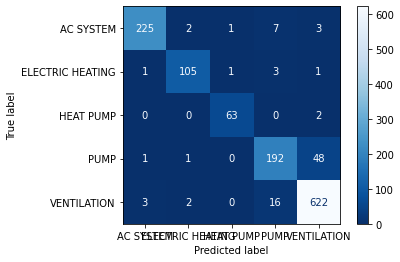

In [7]:
metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

In [8]:
fi = pd.DataFrame.from_dict(zip(model.feature_importances_, model.feature_name_))
fi = fi.sort_values(0, ascending=False)
fi.head()

,0,1
0,1038,nameplate_hp
1,881,nameplate_kW
12,822,percent_on
21,658,jul_operating_hrs
19,567,may_operating_hrs


In [9]:
TYPES=['HEAT PUMP','PUMP']
CONFOUND='percent_on'
df[df.system_type.isin(TYPES)].groupby('system_type')[CONFOUND].max()
df.groupby('system_type')[CONFOUND].max()

system_type
AC SYSTEM           1.0
ELECTRIC HEATING    1.0
HEAT PUMP           1.0
PUMP                1.0
VENTILATION         2.0
Name: percent_on, dtype: float64

In [10]:
# Create a synthetic device slightly towards VENTILATION from AC SYSTEM, but with a CRAZY HIGH annual_kwh.
msv = df.groupby('system_type').mean()

FRAC_T0 = 1
synth_vent_outlier = FRAC_T0 * msv.loc[TYPES[0]] + (1-FRAC_T0) * msv.loc[TYPES[1]]
synth_vent_outlier = synth_vent_outlier.to_frame().T
synth_vent_outlier['assigned_schedule'] = pd.Categorical(['ALL DAY'], categories = df['assigned_schedule'].cat.categories )
#synth_vent_outlier['jul_operating_hrs'] = 2000
#synth_vent_outlier['nameplate_hp'] = 2000
# for c in fi.head()[1]:
#     synth_vent_outlier[c] = df[c].max() * 1.1

In [11]:
display(model.classes_)
pred = model.predict(synth_vent_outlier)[0]
p = model.predict_proba(synth_vent_outlier)[0]
display(p)
display(pred)

array(['AC SYSTEM', 'ELECTRIC HEATING', 'HEAT PUMP', 'PUMP',
       'VENTILATION'], dtype=object)

array([6.99275565e-01, 2.21411934e-04, 4.05224507e-02, 1.52683966e-01,
       1.07296607e-01])

'AC SYSTEM'

In [12]:
# Build a frame of all the predictions
pf = pd.DataFrame(model.predict_proba(x_test), columns = model.classes_)
pf.index = x_test.index

# We're interested in ones where the #1 and #2 choices are close.
pf['Spread'] = np.nan
for c in pf.T:
    r = pf.T[c].sort_values().to_list()
    rv = r[-2] - r[-3]
    pf.loc[c,'Spread'] = rv

# Add a couple of helper columns    
pf['P'] = pf.idxmax(axis=1)
pf['Y'] = y_test

In [13]:
# Subset correct predictions and list a close-race option for each system-type
gf = pf[pf.P==pf.Y]
choices = gf.groupby('P').Spread.idxmin()

# Display options
gf.loc[choices]

,AC SYSTEM,ELECTRIC HEATING,HEAT PUMP,PUMP,VENTILATION,Spread,P,Y
id,,,,,,,,
1017,0.498210,0.000034,0.495833,0.001783,0.004140,0.002377,AC SYSTEM,AC SYSTEM
3460,0.022426,0.681700,0.000077,0.096629,0.199168,0.482531,ELECTRIC HEATING,ELECTRIC HEATING
1715,0.007903,0.120537,0.571239,0.129886,0.170435,0.400803,HEAT PUMP,HEAT PUMP
8314,0.000130,0.000020,0.000012,0.533598,0.466240,0.067358,PUMP,PUMP
8164,0.000084,0.000011,0.000007,0.480087,0.519812,0.039725,VENTILATION,VENTILATION


In [14]:
# Question 1: easy prediction
q1 = df.loc[[3460]].rename(index={3460:1})

# Question 2: hard prediction
q2 = df.loc[[1017]].rename(index={1017:2})

In [27]:
# Create a synthetic entry for Q3
idx = 8164

# Modify a couple vars to put it outside the training volume for important features
q3 = x_test.loc[[idx]].copy()
q3.percent_on = 5.0
q3.nameplate_kW = 30
q3.nameplate_hp = 30
q3.jul_operating_hrs = 1000
q3['assigned_schedule'] = pd.Categorical(['24/7'], categories = df['assigned_schedule'].cat.categories )

# Predict and verify it still predicts properly
pred = model.predict(q3)[0]
probs = model.predict_proba(q3)[0]
display(pd.DataFrame({'System':model.classes_, 'P':probs}).sort_values('P'))
display(f"Prediction: {pred}")
display(f"Label: {y_test[idx]}")

q3['system_type'] = 'VENTILATION'
q3 = q3.rename(index={idx:3})

,System,P
2,HEAT PUMP,0.000024
1,ELECTRIC HEATING,0.000040
0,AC SYSTEM,0.107884
3,PUMP,0.408044
4,VENTILATION,0.484008


'Prediction: VENTILATION'

'Label: VENTILATION'

In [29]:
# Select three questions for 
adf = pd.concat([q1,q2,q3])
adf.to_csv("questions.csv")
adf

,system_type,nameplate_hp,nameplate_kW,Ph,RLA,V,Amps,hp,MLF,Eff,PF,calc_kw,VSD_speed,percent_on,assigned_schedule,scheduled_hours_per_day,jan_operating_hrs,feb_operating_hrs,mar_operating_hrs,apr_operating_hrs,may_operating_hrs,jun_operating_hrs,jul_operating_hrs,aug_operating_hrs,sep_operating_hrs,octob_operating_hrs,nov_operating_hrs,dec_operating_hrs,jan_operating_kWh,feb_operating_kWh,mar_operating_kWh,apr_operating_kWh,may_operating_kWh,jun_operating_kWh,jul_operating_kWh,aug_operating_kWh,sep_operating_kWh,octob_operating_kWh,nov_operating_kWh,dec_operating_kWh,annual_hours,annual_kwh
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,ELECTRIC HEATING,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.700,2.000000,NaN,0.5,ALL DAY,24.0,372.0,336.0,372.0,360.0,372.0,360.0,372.00,372.00,360.0,372.00,360.0,372.00,744.000000,672.000000,744.000000,720.000000,744.000000,720.000000,744.000000,744.000000,720.000000,744.000000,720.000000,744.000000,4380.00,8760.000000
2,AC SYSTEM,NaN,NaN,3.0,16.0,167.0,NaN,6.203807,0.75,0.87,0.758,2.631041,NaN,0.2,ALL DAY,24.0,148.8,134.4,74.4,129.6,148.8,144.0,133.92,104.16,72.0,44.64,28.8,104.16,391.498842,353.611857,195.749421,340.982862,391.498842,378.869847,352.348957,274.049189,189.434923,117.449652,75.773969,274.049189,1267.68,3335.317551
3,VENTILATION,30.0,30.0,NaN,NaN,NaN,NaN,0.083333,0.75,0.75,0.700,0.062167,NaN,5.0,24/7,24.0,744.0,672.0,744.0,720.0,744.0,720.0,1000.00,744.00,720.0,744.00,720.0,744.00,46.252000,41.776000,46.252000,44.760000,46.252000,44.760000,46.252000,46.252000,44.760000,46.252000,44.760000,46.252000,8760.00,544.580000
